# Neural ODE VAE

Implementazione di un Variational AutoEncoder per la ricostruzione, tramite Neural ODE di segnali EEG.

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Scarichiamo i pacchetti necessari.

In [3]:
!pip install torchdiffeq #pacchetto necessario per usare odeint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

MPI per il calcolo parallelo

In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=4458239 sha256=40274e5dd29dbd8f5fb0724680b87c7a428f951d3f91584bd724ecd4ff7326c3
  Stored in directory: /root/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py


We import torchdiffeq which contain Differentiable ODE solvers with full GPU support and O(1)-memory backpropagation.
This library provides ordinary differential equation (ODE) solvers implemented in PyTorch. Backpropagation through ODE solutions is supported using the adjoint method for constant memory cost

Importiamo i pacchetti necessari successivamente.

In [37]:
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import logging
import logging.config
import torch
import torch.optim as optim
from sklearn.decomposition import PCA
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import os
import time
from datetime import datetime as dt
logging.basicConfig(level=logging.INFO)  # Imposta il livello su INFO
import scipy.signal as signal #per il calcolo della potenza
from sklearn.preprocessing import StandardScaler

matplotlib.use('agg')
npr.seed(42)
plt.style.use('ggplot')

#Preprocessing dei dati


1.   Decidiamo il canale EEG su cui lavorare
2.   Carichiamo i dati dal .csv file
3.   Decidiamo l'ampiezza della finestra e la sovrapposizione
4.   Salviamo il file creato come .npy file considerando un tensore con 3 elementi, nel terzo elemento abbiamo due componenti (un indice temporale crescente e il valore eeg)



Trasformiamo il file `eeg_data.csv` da Google Drive e lo salviamo nel Drive nel nuovo formato .npy.

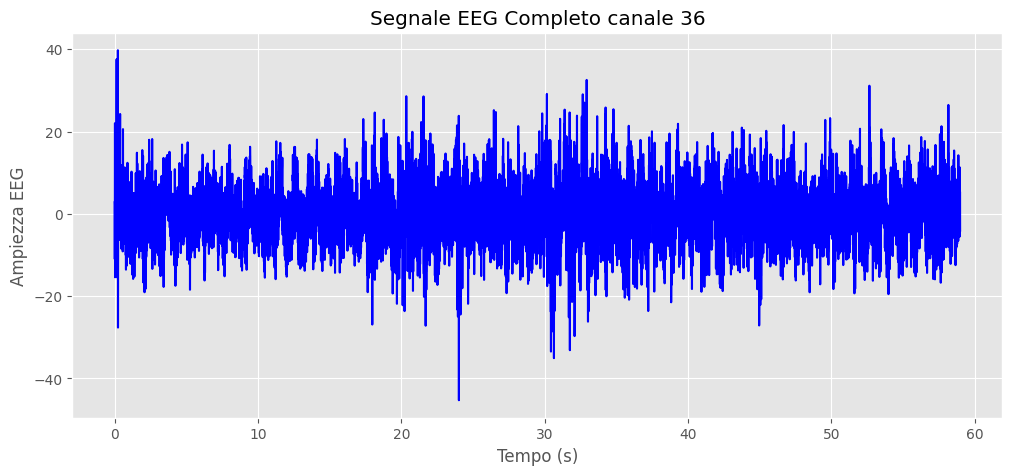

In [5]:
# Load EEG data
channel = 35  # Selecting channel index 36 (Python indexing starts from 0)
data = pd.read_csv("/content/drive/MyDrive/Tesi/eeg_data.csv")

eeg_data_36 = data.iloc[channel, :].to_numpy()
n = eeg_data_36.shape[0]
sampling_rate = 250  # Hz

%matplotlib inline
# Definizione dell'asse temporale
fs = 250  # Frequenza di campionamento (Hz)
n = len(eeg_data_36)  # Numero totale di punti
time_s = np.arange(n) / fs  # Tempo in secondi

# Plot del segnale EEG completo
plt.figure(figsize=(12, 5))
plt.plot(time_s, eeg_data_36, linestyle='-', color='b', label="Segnale EEG Completo")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza EEG")
plt.title("Segnale EEG Completo canale 36")
plt.grid(True)
plt.show()

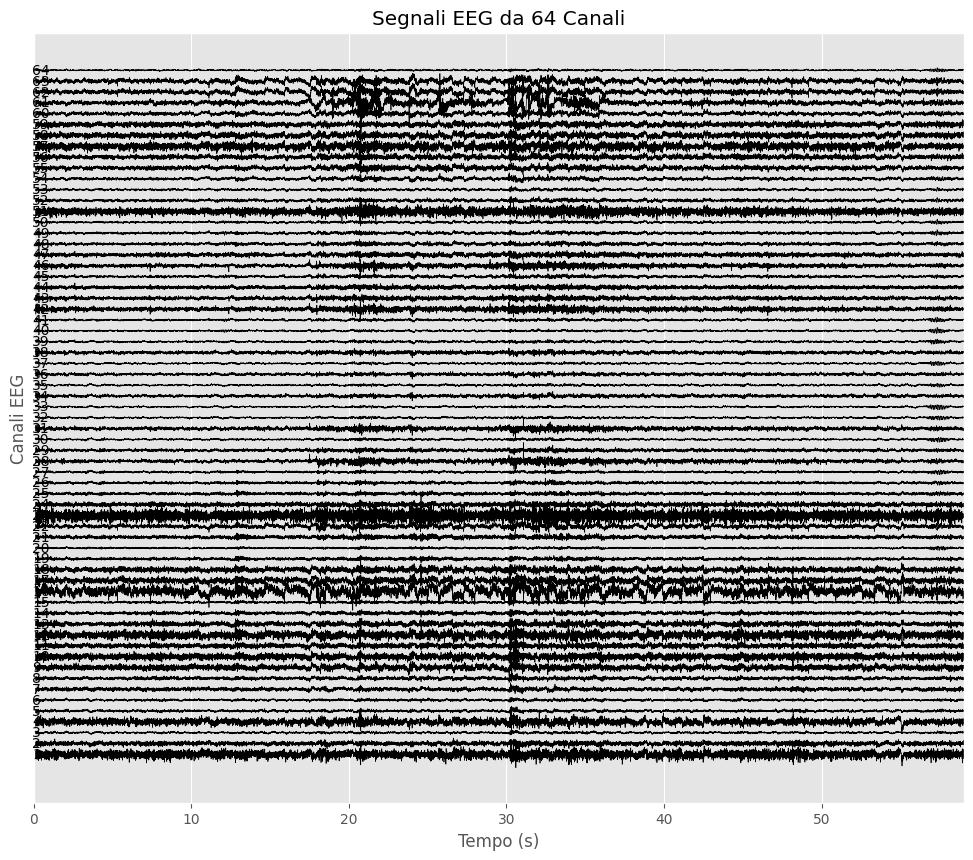

In [23]:
# Carica i dati EEG
data = pd.read_csv("/content/drive/MyDrive/Tesi/eeg_data.csv")

# Imposta il numero di canali e la frequenza di campionamento
num_channels = data.shape[0]
sampling_rate = 250  # Hz
n = data.shape[1]  # Numero di campioni per canale
time_axis = np.linspace(0, n / sampling_rate, n)  # Asse temporale

# Crea il plot
plt.figure(figsize=(12, 10))
offset = 100  # Offset verticale tra i segnali per evitare sovrapposizione
eeg_signals={}

for i in range(num_channels):
    eeg_signals[f'eeg_data_{i+1}']= data.iloc[i, :].to_numpy()  # Estrai il segnale del canale i
    plt.plot(time_axis, eeg_signals[f'eeg_data_{i+1}'] + i * offset, 'k', linewidth=0.5)
    plt.text(time_axis[0] - 0.1, i * offset, f'{i+1}', fontsize=10, verticalalignment='center')

# Configurazione asse
plt.xlabel("Tempo (s)")
plt.ylabel("Canali EEG")
plt.title("Segnali EEG da 64 Canali")
plt.yticks([])  # Rimuove le etichette dell'asse Y per chiarezza
plt.xlim(time_axis[0], time_axis[-1])  # Imposta i limiti dell'asse X
plt.show()

In [24]:
# Definizione delle bande di frequenza
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Low Beta": (13, 20),
    "High Beta": (20, 30)
}

# Dizionario per contenere i segnali filtrati per ciascun canale e banda
filtered_eeg_signals = {band: {} for band in freq_bands}

# Loop su tutti i 64 canali EEG
for i in range(num_channels):
    eeg_data = eeg_signals[f'eeg_data_{i+1}']  # Estrai il segnale
    n = len(eeg_data)  # Numero di campioni
    frequencies = np.fft.fftfreq(n, d=1/sampling_rate)  # Calcola le frequenze
    fft_values = np.fft.fft(eeg_data)  # FFT del segnale

    # Filtro per ogni banda
    for band, (low_f, high_f) in freq_bands.items():
        band_mask = (frequencies >= low_f) & (frequencies <= high_f)
        band_mask |= (frequencies <= -low_f) & (frequencies >= -high_f)  # Mirror delle frequenze

        fft_filtered = np.zeros_like(fft_values, dtype=complex)
        fft_filtered[band_mask] = fft_values[band_mask]  # Mantiene solo le frequenze desiderate

        filtered_signal = np.fft.ifft(fft_filtered).real  # Trasformata inversa per ricostruire il segnale

        # Salva il segnale filtrato nel dizionario
        filtered_eeg_signals[band][f'eeg_data_{i+1}'] = filtered_signal

# Ora hai i segnali filtrati organizzati in:
# filtered_eeg_signals["Delta"]["eeg_data_1"]
# filtered_eeg_signals["Alpha"]["eeg_data_25"]
# filtered_eeg_signals["High Beta"]["eeg_data_64"]

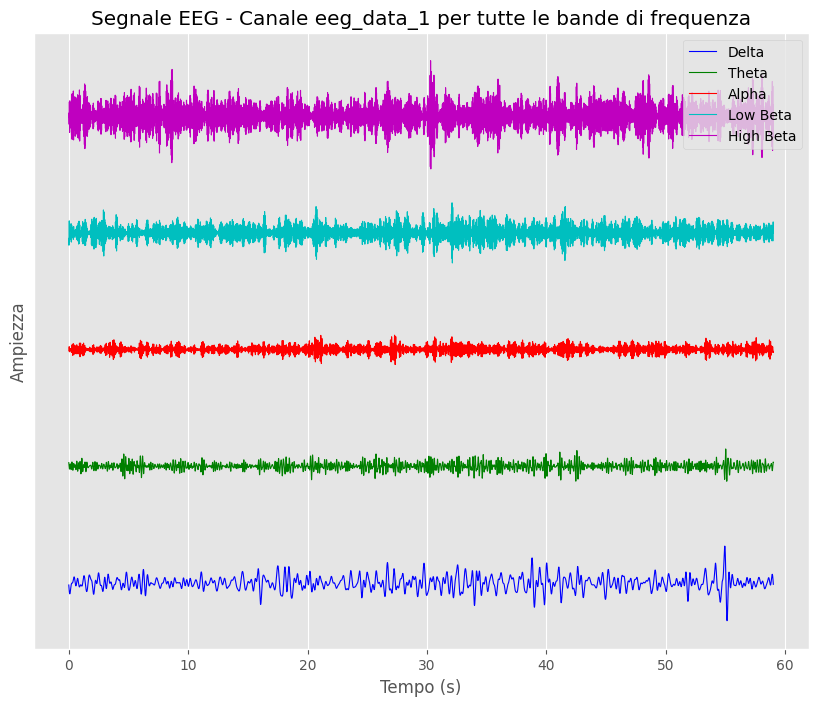

In [25]:
# Seleziona il canale da plottare
selected_channel = "eeg_data_1"  # Cambia con "eeg_data_2", ..., "eeg_data_64"

# Crea il plot
plt.figure(figsize=(10, 8))
time_axis = np.linspace(0, len(filtered_eeg_signals["Delta"][selected_channel]) / sampling_rate,
                   len(filtered_eeg_signals["Delta"][selected_channel]))  # Asse temporale

# Colori per le bande (puoi personalizzarli)
colors = {
    "Delta": "b",
    "Theta": "g",
    "Alpha": "r",
    "Low Beta": "c",
    "High Beta": "m"
}

# Plotta ogni banda per il canale selezionato
for i, (band, color) in enumerate(colors.items()):
    filtered_signal = filtered_eeg_signals[band][selected_channel]
    plt.plot(time_axis, filtered_signal + i * 100, color, linewidth=0.8, label=f'{band}')  # Offset per separare i segnali

# Configurazione asse
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.title(f"Segnale EEG - Canale {selected_channel} per tutte le bande di frequenza")
plt.legend()
plt.grid(True)
plt.yticks([])  # Rimuove le etichette dell'asse Y per chiarezza
plt.show()


Divisione segnale originale in sottofinestre con ampiezza: window_size e overlap: 50% di window_size

In [26]:
# Imposta parametri della finestra
window_size = 20  # 1 secondo di dati (250 campioni)
overlap = int(0.5 * window_size)  # Sovrapposizione del 50%
step_size = window_size - overlap  # Passo tra finestre

# Loop su tutti i canali
for channel in range(1,num_channels+1):  # Da 1 a 64
    selected_channel = f"eeg_data_{channel}"  # Nome chiave nel dizionario

    # Loop su tutte le bande di frequenza
    for band in filtered_eeg_signals.keys():
        signal = filtered_eeg_signals[band][selected_channel]  # Segnale filtrato

        # Numero di finestre che possiamo estrarre
        n = len(signal)
        n_windows = (n - overlap) // step_size
        eeg_windows = np.zeros((n_windows, window_size, 2))  # Shape (num_windows, window_size, 2)

        # Creazione delle finestre con sovrapposizione
        for i in range(n_windows):
            start_idx = i * step_size
            end_idx = start_idx + window_size
            eeg_windows[i, :, 0] = np.arange(1, window_size + 1)  # Indici temporali
            eeg_windows[i, :, 1] = signal[start_idx:end_idx]  # Valori EEG filtrati

        # Salva il file `.npy`
        save_path = f"/content/drive/MyDrive/Tesi/eeg_{band}_channel_{channel}_windows.npy"
        np.save(save_path, eeg_windows)
        print(f"Salvato: {save_path}")

print(f"Numero di finestre totali per canale: {n_windows}")

Salvato: /content/drive/MyDrive/Tesi/eeg_Delta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Theta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Alpha_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Low Beta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_High Beta_channel_1_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Delta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Theta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Alpha_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Low Beta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_High Beta_channel_2_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Delta_channel_3_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Theta_channel_3_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Alpha_channel_3_windows.npy
Salvato: /content/drive/MyDrive/Tesi/eeg_Low Beta_channel_3_windows.npy
Salvato: /content

Plot della prima finestra

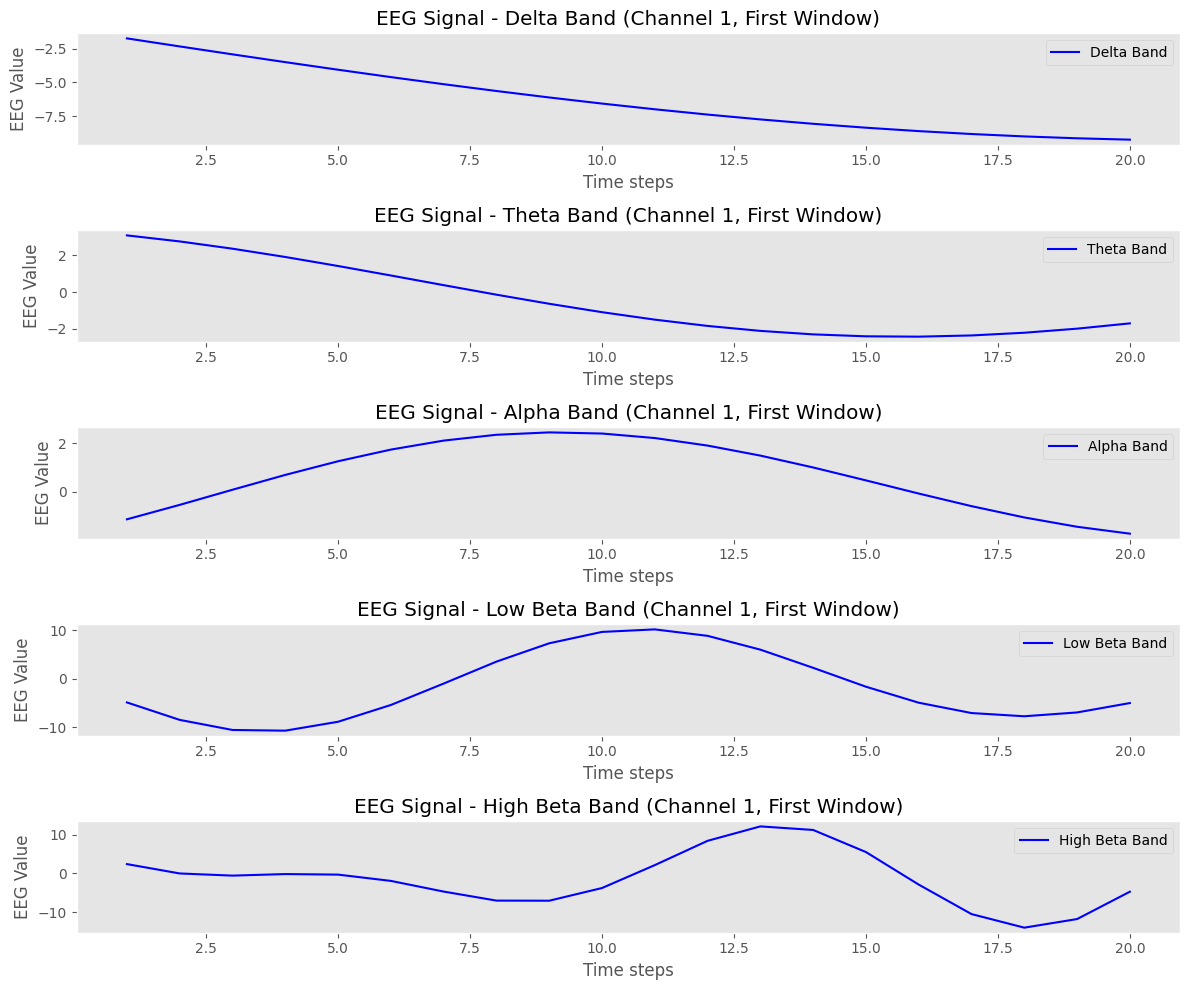

In [27]:
# Seleziona il canale da plottare
selected_channel = 1  # Cambia con il numero del canale desiderato (1-64)

# Definizione delle bande di frequenza e percorso file
freq_bands = ["Delta", "Theta", "Alpha", "Low Beta", "High Beta"]
file_path_template = "/content/drive/MyDrive/Tesi/eeg_{}_channel_{}_windows.npy"

# Creazione della figura
plt.figure(figsize=(12, 10))

for i, band in enumerate(freq_bands):
    #Carica il file .npy per la banda corrente e il canale selezionato
    file_path = file_path_template.format(band, selected_channel)
    eeg_windows = np.load(file_path)

    # Estrarre la prima finestra
    first_window = eeg_windows[0]  # Prima finestra temporale
    time_index = first_window[:, 0]  # Indice temporale (1 a 250)
    eeg_values = first_window[:, 1]  # Valori EEG della banda corrente

    # Plot della banda
    plt.subplot(5, 1, i + 1)
    plt.plot(time_index, eeg_values, label=f"{band} Band", color='b')
    plt.xlabel("Time steps")
    plt.ylabel("EEG Value")
    plt.title(f"EEG Signal - {band} Band (Channel {selected_channel}, First Window)")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Lo scaler va fittato sul training set, poi si applica lo scaler
mai normalizzare i dati del
fit--> allena oggetto scaler a standardizzare i dati
transform--> trasforma i dati del test, utilizzando lo scaler allenato nei dati del training
normalizzazione prima del training
poi salvare oggetto scaler, prima di prendere il modello allenato normalizzare i dati del test con lo scaler allenato sul training.

provare a prendere tutti i canali e fare un unico training set, però va tolto il contributo del singolo canale sul singolo segnale. Mettendoli tutti insieme i dati devono essere. Bisogna far sì che tutti siano significativi, compararli fra loro.

provare dataset pubblici EEG con stesse condizioni--> condizione baseline

| Time steps | secondi |
|-----------|-----------|
| 250    | 1s  |
| 10    | 0.04s  |
| Riga 3    | Valore 3  |
| Riga 4    | Valore 4  |
| Riga 5    | Valore 5  |


Visualizzazione dei dati (prime 5 finestre)

**Suggerimenti/Indicazioni**
* guardare k-fold Cross Validation (hyperparameter tuning)--> questa tecnica per capire come scegliere gli iper parametri
* aumentare il training set
* provare a ricostruire dati che non sono baseline con modello allenato su dati baseline (quindi ci aspettiamo
* segnare ELBO e RMSE tra vero e ricostruito (per fare un anomaly detection dovremo decidere una soglia per capire se è baseline o no)

`data.py`

In [28]:
class Data:
    def __init__(self, orig_trajs, samp_trajs, orig_ts, samp_ts, labels=None, device=None):
        if device is None: #se il device non è stato assegnato allora usa la CPU
            device = 'cpu'

        try:
            orig_trajs = torch.from_numpy(orig_trajs).float()
            samp_trajs = torch.from_numpy(samp_trajs).float()
            samp_ts = torch.from_numpy(samp_ts).float()
            orig_ts = torch.from_numpy(orig_ts).float()

        except Exception:
            logging.warning('Inputs cannot be converted to torch (already a torch obj?)\n'
                            f'Types: {type(orig_trajs), type(samp_trajs), type(orig_ts), type(samp_ts)} ')

        #sposta sul device i parametri
        self.samp_ts = samp_ts.to(device)
        self.samp_trajs = samp_trajs.to(device)
        self.orig_ts = orig_ts.to(device)
        self.orig_trajs = orig_trajs.to(device)
        self.labels = labels
        #splitta i dati tra la parte di training e validation
        self.split(orig_trajs, samp_trajs, labels)

#aggiunta ma da capire se serve o no
    def get_samp_ts(self):
        return self.samp_ts

    @classmethod #possiamo chiamare questo metodo direttamente dalla classe, senza crearne un'istanza
    #NB: nei metodi di classe si usa cls per riferirsi alla classe stessa in modo generico
    def from_func(cls, func, device, **args):
        return cls(*func(**args), device=device)
        #Questo metodo chiama la funzione func (in questo caso load_data).load_data restituisce quattro tensori. Questi tensori vengono passati come argomenti alla classe Data, che li usa per creare un'istanza dell'oggetto Data.

    #divide il dataset in 3 insiemi: 60-20-20
    def split(self, orig_trajs, samp_trajs, labels, train_split=0.6, val_split=0.2):
        # We split the data across the spring dimension [nr. springs, nr. samples, values]
        train_int = int(train_split * orig_trajs.shape[0])  # X% of the data length for training, posizione dell'elemento dove termina il training set
        val_int = int((train_split + val_split) * orig_trajs.shape[0])  # X% more for validation, posizione dell'elemento dove termine il validation set

        #divisione delle traiettorie originali
        self.orig_trajs_train, self.orig_trajs_val, self.orig_trajs_test = (orig_trajs[:train_int, :, :],
                                                                            orig_trajs[train_int:val_int, :, :],
                                                                            orig_trajs[val_int:, :, :])
        #divisione delle traiettorie campionate
        self.samp_trajs_train, self.samp_trajs_val, self.samp_trajs_test = (samp_trajs[:train_int, :, :],
                                                                            samp_trajs[train_int:val_int, :, :],
                                                                            samp_trajs[val_int:, :, :])
        #divisione delle etichette, se presenti
        if labels:
            self.labels_train, self.labels_val, self.labels_test = (labels[:train_int],
                                                                    labels[train_int:val_int],
                                                                    labels[val_int:])

    def get_train_data(self):
        return self.samp_trajs_train, self.samp_ts

    def get_val_data(self):
        return self.samp_trajs_val, self.samp_ts

    def get_test_data(self):
        return self.samp_trajs_test, self.samp_ts, self.orig_trajs_test, self.orig_ts

    def get_all_data(self):
        return self.orig_trajs, self.samp_trajs, self.orig_ts, self.samp_ts

    def get_train_labels(self):
        return self.labels_train

    def get_val_labels(self):
        return self.labels_val

    def get_test_labels(self):
        return self.labels_test

    def get_all_labels(self):
        return self.labels

    @classmethod #metodo che non necessita di un'istanza della classe per essere chiamato
    def from_dict(cls, dict, device=None): #a partire da un dizionario dict crea un'istanza della classe
        labels = None
        if 'labels' in dict:
            labels = dict['labels']
            logging.info("Loading data labels")

        return cls(
            dict['orig_trajs'],
            dict['samp_trajs'],
            dict['orig_ts'],
            dict['samp_ts'],
            labels,
            device
        )

    def get_dict(self):
        return {
            'orig_trajs': self.orig_trajs,
            'samp_trajs': self.samp_trajs,
            'orig_ts': self.orig_ts,
            'samp_ts': self.samp_ts,
            'labels': self.labels,
        }

Cross validation: dividere prima il dataset in training e test poi il training si dividerà in training e validation. Provo diversi parametri, guardo la performance sul validation, per ogni combinazione di iperparametri valutare le performance cercando di capire quali sono le performance migliori. Capire se è in grado con un set di dati mai visto.

`visualize.py`

In [41]:
class Visualizer:
    def __init__(self,model, data: Data, save_folder: str):
        self.model = model
        self.data = data
        self.save_folder = save_folder + 'png/'
        self.device = model.device

    def compute_band_power(self, signal_data, band):
        """
        Calcola la potenza del segnale in una specifica banda di frequenza.

        signal_data: array EEG nel dominio del tempo, di forma (num_finestre, window_size)
        band: (f_min, f_max) intervallo di frequenza della banda EEG in cui calcolare la potenza
        """
        #fs è la frequenza di campionamento
        f, Pxx = signal.welch(signal_data, fs, nperseg=fs)  # PSD calcolata con il metodo Welch
        #f: array delle sequenze associate alla PSD
        #Pxx: array contentente la PSD per ogni finestra temporale
        f_min, f_max = band
        idx_band = np.logical_and(f >= f_min, f <= f_max)  # Filtriamo la banda desiderata creando un booleano che è True solo per le frequenze desiderate
        power = np.trapz(Pxx[:, idx_band], f[idx_band], axis=1)  # Integrazione numerica della PSD nella banda selezionata usando la regola del trapezio--> stima della potenza del segnale nella banda scelta

        return power #array contentente la potenza nella banda selezionata

    def compute_power_bands(self):
        """
        Confronta la potenza nelle bande di frequenza tra segnali EEG reali e ricostruiti.
        """
        # Estrazione dei dati: dati originali, versione campionata del segnale e timestamp associati ai dati campionati
        orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()

        with torch.no_grad(): #disabilita il calcolo del gradiente per evitare di occupare memoria inutilmente
            if isinstance(self.model, ODEAutoEncoder): #se il modello è un ODEAutoEncoder
                pred_x = self.model.forward(samp_trajs, samp_ts) #viene eseguito il forward pass sulla versione campionata

        # Conversione in NumPy
        orig_trajs = orig_trajs.cpu().numpy()
        pred_x = pred_x.cpu().numpy()

        # Definizione delle bande EEG
        bands = {
            "Delta": (0.5, 4), #sonno profondo
            "Theta": (4, 8), #sonno leggero, rilassamento
            "Alpha": (8, 13), #stato di calma, veglia
            "Beta": (13, 30), #attività cognitiva
            "Gamma": (30, 100)
        }

        # Calcolo della potenza per ogni banda
        power_orig = {band: self.compute_band_power(orig_trajs[:, :, 1], freq_range) for band, freq_range in bands.items()} #potenza del segnale originale
        power_pred = {band: self.compute_band_power(pred_x[:, :, 1], freq_range) for band, freq_range in bands.items()} #potenza del segnale ricostruito

        # Confronto tra segnali reali e ricostruiti
        for band in bands.keys():
            mean_orig = np.mean(power_orig[band])
            mean_pred = np.mean(power_pred[band])
            #print(f"Potenza media nella banda {band}:")
            #print(f"  - Segnale originale: {mean_orig:.4f}")
            #print(f"  - Segnale ricostruito: {mean_pred:.4f}")
            #print(f"  - Differenza: {abs(mean_orig - mean_pred):.4f}")

        return power_orig, power_pred

    def visualize_step(self, version):
        now = dt.now().strftime('%H_%M')
        fname = f'v{version}_{now}.png'

        self.plot_reconstruction(fname)

    def visualize_final(self, version, t_pos=np.pi, t_neg=np.pi):
        now = dt.now().strftime('%H_%M')
        fname = f'{version}_{now}'
        self.plot_reconstruction(fname + '_reconstruction.png', t_pos=t_pos, t_neg=t_neg)
        self.plot_loss_history(fname + '_loss_history.png')
        self.plot_reconstruction_grid(fname + '_reconstruction_grid.png', t_pos=t_pos, t_neg=t_neg)
        self.plot_original_grid(fname + '_original_grid.png')

    def latent_vis(self, fname, z_traj_idx=None, test=False, label=None, saved_data=None):
        # We make sure that we plot for the test sample trajectories if test = True
        if test:
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()
            if label is None:
                label = self.data.get_test_labels()
        else:
            orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()
            if label is None:
                label = self.data.get_all_labels()

        with torch.no_grad():
            if isinstance(self.model, ODEAutoEncoder):
                # We forward pass to extract pred_x and z0 (we will only use z0)
                if saved_data is not None:
                    qz0_mean, qz0_logvar, epsilon = self.model.encode(saved_data)
                else:
                    qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)

                # Sample z0 (vector) from q(z0)
                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)
                print("z0 size", z0.size())

                pca = PCA(n_components=2)
                pca.fit(z0)
                print("Explained variance:", pca.explained_variance_ratio_)
                z0_red = pca.fit_transform(z0)

                # print(z0_red.shape)
                print(z0_red[:, 0].shape)
                print(len(label))

                # df=pd.DataFrame(z0_red,label)
                d = {'PC1': z0_red[:, 0], 'PC2': z0_red[:, 1], 'Label': label}
                df = pd.DataFrame(d)

                # print(len(df[df.Label==3].PC1))

                # z0 latent space plot
                if label is not None:
                    plt.figure()
                    # z0 samples in 2D
                    for i in np.unique(label):
                        colors = ["dummy", "#c4564f", "#51a66e", "#2697f0"]
                        plt.plot(df[df.Label == i].PC1, df[df.Label == i].PC2, 'o', color=colors[i],
                                 label=f' Spring type {i}', linewidth=2,
                                 zorder=1)
                    plt.legend()
                else:
                    plt.figure()
                    plt.plot(z0_red[:, 0], z0_red[:, 1], 'o', label='z0 samples in 2D', linewidth=2,
                             zorder=1)
                    plt.legend()

                logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
                plt.savefig(self.save_folder + 'z0' + fname, dpi=250)
                if z_traj_idx is not None:
                    ts_rmse = torch.from_numpy(np.linspace(0., torch.max(samp_ts), num=len(samp_ts))).to(self.device)
                    pred_x, pred_z = self.model.decode(z0, ts_rmse, return_z=True)

                    # print(pred_z.size())
                    # print(pred_z)

                    pca_z = PCA(n_components=2)
                    pca_z.fit(pred_z[z_traj_idx, :, :])
                    # print(pca_z.explained_variance_ratio_)
                    pred_z_red = pca_z.fit_transform(pred_z[z_traj_idx, :, :])
                    # print(pred_z_red.shape)

                    stype = label[z_traj_idx]
                    print(stype)
                    plt.figure()
                    plt.plot(pred_z_red[:, 0], pred_z_red[:, 1], 'o', color=colors[stype],
                             label=f'latent traj Spring type {stype}', linewidth=2,
                             zorder=1)
                    plt.legend()

                    logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
                    plt.savefig(self.save_folder + 'z_traj' + fname, dpi=250)

            elif isinstance(self.model, LSTMAutoEncoder):
                logging.info('Cannot sample latent space from Autoencoder baseline')


    def plot_reconstruction(self, fname, t_pos=np.pi, t_neg=np.pi, idx=0, test=False, toy=False):
        orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()# We unwrap the trajectories from the data object
        #print("Valori asse x tempo: ",orig_trajs[idx, :, 0])

        # We make sure that we plot for the test sample trajectories if test = True
        if test: #la variabile test viene attivata per distinguere tra la modalità di addestramento o test
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()

        with torch.no_grad(): #PyTorch non memorizza i gradienti intermedi necessari per la backpropagation
            if isinstance(self.model, ODEAutoEncoder): #controlla se il modello è un ODEAutoEncoder

                qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)# We forward pass to extract pred_x and z0 (we will only use z0)

                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)# Sample z0 (vector) from q(z0)

                # We generate new linspaces for extrapolation and negative extrapolation | We use the decode function to extract pred_x
                #ts_rmse = torch.from_numpy(np.linspace(1., torch.max(samp_ts).cpu().item(), num=len(samp_ts))).to(self.device)

                #ricostruzione
                ts_rec=samp_ts
                pred_x_rec=self.model.decode(z0,ts_rec)

            # Creiamo una finestra temporale per l'extrapolazione
                extrapolation_window = 10  # Numero di passi di extrapolazione
                num_extra_points = 3  # Quanti punti generare nell'extrapolazione

            # Creiamo la sequenza temporale per l'extrapolazione (pochi punti, non equidistanti)
                ts_max = torch.max(samp_ts).cpu().item()
                ts_extra = np.linspace(ts_max, ts_max + extrapolation_window, num=num_extra_points)
                ts_extra = torch.from_numpy(ts_extra).to(self.device)

            # Generiamo la traiettoria extrapolata con pochi punti
                pred_x_pos = self.model.decode(z0, ts_extra)

                #ts_pos = torch.from_numpy(np.linspace(0, torch.max(samp_ts).cpu().item() + t_pos, num=int(len(samp_ts)))).to(self.device)


                #pred_x_pos = self.model.decode(z0, ts_pos)
                #pred_x_rmse = self.model.decode(z0, ts_rmse)

                #val = int((t_pos / (torch.max(samp_ts) + t_pos)) * len(samp_ts)) #numero di punti di estrapolazione
                #pred_x_rec = pred_x_pos[:, :(len(samp_ts) - val), :]
                #pred_x_pos = pred_x_pos[:, (len(samp_ts) - val - 1):, :]
                #pred_x_rec=pred_x_pos[:,:]

#calcolo RMSE
                rmse_loss = self.RMSELoss(pred_x_rec, samp_trajs)
                logging.info(f'RMSE: {rmse_loss}')
#calcolo media
                mean_yhat, mean_y = self.compute_means(pred_x_rec, samp_trajs)
                print(f"Media di yhat: {mean_yhat.item()}, Media di y: {mean_y.item()}")
#calcolo della correlazione
                pearson_corr = self.compute_pearson_correlation(pred_x_rec, samp_trajs)
                print("La correlazione è pari a: ", pearson_corr)
#calcolo della varianza
                var_yhat, var_y=self.compute_var(pred_x_rec,samp_trajs)
                print("La varianza di yhat: ",var_yhat, "La varianza di y: ",var_y)

#calcolo della potenza
               # power=self.compute_power_bands()

                pred_x_pos = pred_x_pos.cpu().detach().numpy()
                pred_x_rec = pred_x_rec.cpu().detach().numpy()

                # We plot only the first trajectory
                orig_trajs = orig_trajs.cpu().detach()
                samp_trajs = samp_trajs.cpu().detach()

                if (t_neg > 0):
                    ts_neg = torch.from_numpy(np.linspace(-t_neg, 0., num=int(len(samp_ts) / 8))[::-1].copy()).to(
                        self.device)
                    pred_x_neg = torch.flip(self.model.decode(z0, ts_neg), dims=[1]).cpu().detach().numpy()

                    plt.figure()
                    plt.plot(orig_trajs[idx, :, 0].cpu().numpy(), orig_trajs[idx, :, 1].cpu().numpy(), 'g', label='True trajectory', linewidth=2,
                             zorder=1)

                    if isinstance(pred_x_rec, torch.Tensor):
                        pred_x_rec = pred_x_rec.cpu().numpy()

                    plt.plot(pred_x_rec[idx, :, 0], pred_x_rec[idx, :, 1], '-o', color='r', markersize=3,label='Reconstruction', zorder=3)

                    if isinstance(pred_x_pos, torch.Tensor):
                        pred_x_pos = pred_x_pos.cpu().numpy()

                    #plt.plot(pred_x_pos[idx, :, 0], pred_x_pos[idx, :, 1], '-o', color='c', markersize=3,
                    #label='Learned trajectory (t>0)', zorder=2)

                  # Se pred_x_neg è un tensore, converti in NumPy
                    if isinstance(pred_x_neg, torch.Tensor):
                        pred_x_neg = pred_x_neg.cpu().numpy()

                    #plt.plot(pred_x_neg[idx, :, 0], pred_x_neg[idx, :, 1], '-o', color='c', markersize=3,
                    #label='Learned trajectory (t<0)', zorder=2)
                    plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='Sampled data', s=10,
                                zorder=2)
                    plt.legend()
                else:
                    plt.figure()
                    plt.plot(orig_trajs[idx, :, 0].cpu().numpy(), orig_trajs[idx, :, 1].cpu().numpy(), 'g', label='True trajectory', zorder=1)
                    plt.plot(pred_x_rec[idx, :, 0], pred_x_rec[idx, :, 1], '-o', color = 'r', markersize = 3, label='Reconstruction', zorder=3)
                    #plt.plot(pred_x_pos[idx, :, 0].cpu().numpy(), pred_x_pos[idx, :, 1].cpu().numpy(), '-o', color='c', markersize=3,
                             #label='Learned trajectory (t>0)', zorder=3)
                    plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='Sampled data', s=3,
                                zorder=2)
                    plt.legend()

            elif isinstance(self.model, LSTMAutoEncoder):
                pred_x = self.model.forward(samp_trajs)

                plt.figure()
                plt.plot(orig_trajs[idx, orig_trajs[idx, :, 0] >= 0, 0].cpu().numpy(), orig_trajs[idx, orig_trajs[idx, :, 0] >= 0, 1].cpu().numpy(), 'g', label='true trajectory', zorder=1)
                plt.plot(pred_x[idx, :, 0].cpu().numpy(), pred_x[idx, :, 1].cpu().numpy(), 'r', label='learned trajectory (t>0)', zorder=3)
                plt.scatter(samp_trajs[idx, :, 0].cpu().numpy(), samp_trajs[idx, :, 1].cpu().numpy(), color='b', label='sampled data', s=3,
                            zorder=2)
                plt.legend()


        logging.info('Saved reconstruction at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

        # Definisci la cartella per salvare le finestre ricostruite
        save_dir = "/content/drive/MyDrive/Tesi/Reconstructions/"
        os.makedirs(save_dir, exist_ok=True)
        # Salva la ricostruzione finale per ogni finestra
        np.save(f"{save_dir}final_reconstruction_{band}_{channel}.npy", pred_x_rec if isinstance(pred_x_rec, np.ndarray) else pred_x_rec.cpu().detach().numpy())


    def plot_reconstruction_grid(self, fname, t_pos=np.pi, t_neg=np.pi, size=5, test=False):
        # We unwrap the trajectories from the data object
        orig_trajs, samp_trajs, _, samp_ts = self.data.get_all_data()

        # We make sure that we plot for the test sample trajectories if test = True
        if test:
            samp_trajs, samp_ts, orig_trajs, _ = self.data.get_test_data()

        with torch.no_grad():
            if isinstance(self.model, ODEAutoEncoder):
                # We forward pass to extract pred_x and z0 (we will only use z0)
                qz0_mean, qz0_logvar, epsilon = self.model.encode(samp_trajs)

                # Sample z0 (vector) from q(z0)
                z0 = self.model.sample_z0(epsilon, qz0_logvar, qz0_mean)

                # We generate new linspaces for extrapolation and negative extrapolation | We use the decode function to extract pred_x
            # Converte torch.max(samp_ts) in un numero scalare prima di passarlo a NumPy
                max_samp_ts = torch.max(samp_ts).cpu().item()

                ts_pos = torch.from_numpy(np.linspace(0., max_samp_ts + t_pos, num=len(samp_ts))).to(self.device)
                pred_x_pos = self.model.decode(z0, ts_pos).cpu().detach().numpy()

                if t_neg > 0:
                    ts_neg = torch.from_numpy(np.linspace(-t_neg, 0., num=int(len(samp_ts) / 8))[::-1].copy()).to(
                        self.device)
                    pred_x_neg = torch.flip(self.model.decode(z0, ts_neg), dims=[1]).cpu().detach().numpy()

                # Define extrapolation
                #val = int((t_pos / (torch.max(samp_ts) + t_pos)) * len(samp_ts))
                val=0
                pred_x_rec = pred_x_pos[:, :(len(samp_ts) - val), :]
                pred_x_pos = pred_x_pos[:, (len(samp_ts) - val - 1):, :]

                orig_trajs = orig_trajs.cpu().detach()
                samp_trajs = samp_trajs.cpu().detach()

                plt.figure(figsize=(15, 15))
                for i in range(size ** 2):
                    # We scale all y values to be 0:1
                    min_traj_y = np.min(orig_trajs.numpy()[i, :, 1])
                    max_traj_y = np.max(orig_trajs.numpy()[i, :, 1])
                    pred_x_rec_plt_y = (pred_x_rec[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                    pred_x_pos_plt_y = (pred_x_pos[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                    orig_trajs_plt_y = (orig_trajs[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)

                    # We scale all x values to be 0:1
                    min_traj_x = np.min(orig_trajs.numpy()[i, :, 0])
                    max_traj_x = np.max(orig_trajs.numpy()[i, :, 0])
                    pred_x_rec_plt_x = (pred_x_rec[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                    pred_x_pos_plt_x = (pred_x_pos[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                    orig_trajs_plt_x = (orig_trajs[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)

                    plt.subplot(size, size, i + 1)
                    plt.plot(pred_x_rec_plt_x, pred_x_rec_plt_y, '-o', color='r', markersize=1, label='Reconstruction',
                             zorder=3)
                    plt.plot(orig_trajs_plt_x, orig_trajs_plt_y, color='g', linewidth=1, label='True trajectory',
                             markersize=1, zorder=1)
                    #if t_pos > 0:
                        #plt.plot(pred_x_pos_plt_x, pred_x_pos_plt_y, '-o', color='c', markersize=3,
                                 #label='Learned trajectory (t>0)', zorder=2)
                    #if t_neg > 0:
                        #pred_x_neg_plt_y = (pred_x_neg[i, :, 1] - min_traj_y) / (max_traj_y - min_traj_y)
                        #pred_x_neg_plt_x = (pred_x_neg[i, :, 0] - min_traj_x) / (max_traj_x - min_traj_x)
                        #plt.plot(pred_x_neg_plt_x, pred_x_neg_plt_y, '-o', color='c', markersize=3,
                                 #label='Learned trajectory (t<0)', zorder=2)

                plt.legend(
                    #['Reconstruction', 'True trajectory', 'Learned trajectory (t>0)', 'Learned trajectory (t<0)'])
                    ['Reconstruction', 'True trajectory'])

            elif isinstance(self.model, LSTMAutoEncoder):
                pred_x = self.model.forward(samp_trajs)

                plt.figure(figsize=(15, 15))

                for i in range(size ** 2):
                    plt.subplot(size, size, i + 1)
                    plt.plot(orig_trajs[i, :, 0], orig_trajs[i, :, 1], 'g', label='true trajectory', zorder=1)
                    plt.plot(pred_x[i, :, 0], pred_x[i, :, 1], 'r', label='learned trajectory (t>0)', zorder=3)
                    plt.scatter(samp_trajs[i, :, 0], samp_trajs[i, :, 1], color='b', label='sampled data', s=3,
                                zorder=2)
                plt.legend()

            logging.info('Saved reconstruction grid plot at {}'.format(self.save_folder + fname))
            plt.savefig(self.save_folder + fname, dpi=250)

    def plot_original_grid(self, fname):
        # We unwrap the trajectories from the data object
        orig_trajs, _, _, _ = self.data.get_all_data()

        orig_trajs = orig_trajs.cpu().detach()

        plt.figure(figsize=(15, 15))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.scatter(x=orig_trajs[i, :, 0], y=orig_trajs[i, :, 1], color='b')

        plt.legend(['orig_trajs'])

        logging.info('Saved original grid plot at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

    def plot_loss_history(self, fname):
        plt.figure(figsize=(15, 15))
        plt.plot(self.model.train_loss, color='b')
        plt.plot(self.model.val_loss, color='r')

        plt.legend(['train ELBO', 'validation ELBO'])

        logging.info('Saved loss plot at {}'.format(self.save_folder + fname))
        plt.savefig(self.save_folder + fname, dpi=250)

    def plot_latent_space(self, fname):
        # We unwrap the trajectories from the data object
        orig_trajs, samp_trajs, orig_ts, samp_ts = self.data.get_all_data()

        # We forward pass to extract pred_x and z0
        pred_x, z0 = self.model.forward(samp_trajs, samp_ts, return_z0=True)

        # We use the decode function to extract pred_z
        pred_z = self.model.decode(z0, samp_ts, return_z=True)

        # Dunno if this is necessary
        pred_z = pred_z.cpu().detach().numpy()

        # We create the plot
        plt.figure(figsize=(15, 15))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.scatter(x=pred_z[i, :, 0], y=pred_z[i, :, 1], color='r')
        plt.legend(['pred_z,'])
        plt.savefig(fname, dpi=250)
        plt.show()

    def plot_extrapolation(self):
        pass

    def RMSELoss(self, yhat, y):
        assert type(yhat) == torch.Tensor
        assert type(y) == torch.Tensor
        return torch.sqrt(torch.mean((yhat - y) ** 2))

    def compute_means(self, yhat, y):
      #verifica che entrambi gli input siano tensori PyTorch
        assert isinstance(yhat, torch.Tensor)
        assert isinstance(y, torch.Tensor)

        mean_yhat = torch.mean(yhat)
        mean_y = torch.mean(y)

        return mean_yhat, mean_y

    def compute_var(self,yhat,y):
        assert isinstance(yhat,torch.Tensor)
        assert isinstance(y,torch.Tensor)

        var_yhat = torch.var(yhat, unbiased=False)  # Varianza di yhat
        var_y = torch.var(y, unbiased=False)  # Varianza di y

        return var_yhat, var_y

    def compute_pearson_correlation(self, yhat, y): #misura la correlazione lineare tra due tensori (valore tra -1 e 1)
    #controlla che entrambi gli input siano tensori PyTorch
        assert isinstance(yhat, torch.Tensor)
        assert isinstance(y, torch.Tensor)

        #calcolo medie
        x_mean = torch.mean(yhat)
        y_mean = torch.mean(y)
        #print("La forma di yhat e y è: ", yhat.shape, y.shape)

        #centratura
        x_diff = yhat - x_mean
        y_diff = y - y_mean

        #calcolo del numeratore della formula di Pearson
        numerator = torch.sum(x_diff * y_diff)
        denominator = torch.sqrt(torch.sum(x_diff ** 2) * torch.sum(y_diff ** 2)) #radice quadrata del prodotto delle varianze

        correlation = numerator / (denominator + 1e-8)  # Per evitare divisioni per zero
        return correlation


    def computeRMSE_VAE(self, samp_trajs, samp_ts):
        with torch.no_grad():
            pred_x_rmse = self.model.forward(samp_trajs, samp_ts)
            rmse_loss = self.RMSELoss(pred_x_rmse, samp_trajs)

            return (rmse_loss.cpu().detach().numpy(), pred_x_rmse)

    def computeRMSE_AE(self, samp_trajs):
        with torch.no_grad():
            pred_x_rmse = self.model.forward(samp_trajs)
            rmse_loss = self.RMSELoss(pred_x_rmse, samp_trajs)

            return (rmse_loss.cpu().detach().numpy(), pred_x_rmse)


y e yhat = (numero di finestre, window_size)

`model.py`

Funzioni utili per i successivi calcoli della ELBO:

$$
D_{\text{KL}}(q(z_0) \parallel p(z_0)) = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}
$$


$$
\log p(x) = -\frac{1}{2} \left( \log(2\pi) + \log\sigma^2 + \frac{(x - \mu)^2}{\sigma^2} \right)
$$


fisso la logvar=-10 poiché il segnale EEG è privo di rumore.

In [42]:
###########################################
# UTILITY FUNCTIONS
###########################################

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl


###########################################
# ABSTRACT TRAINER MODEL
###########################################

class TrainerModel(nn.Module):
    train_loss = []
    val_loss = []
    epoch_time = []

    def train_step(self, x, t):
        x = x.to(self.device)  # Assicura che x sia su GPU
        t = t.to(self.device)  # Assicura che t sia su GPU

        pred_x = self.forward(x)
        raise NotImplementedError()

    @classmethod
    def from_checkpoint(cls, path):
        raise NotImplementedError()

    def get_params(self):
        raise NotImplementedError()

    def get_args(self):
        raise NotImplementedError()

    def get_state_dicts(self):
        raise NotImplementedError()


###########################################
# ODE IMPLEMENTATION --> definisce l'ODE latente dz(t)/dt=f
###########################################

class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20): #implementato come una rete neurale (ELU+MLP)
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)

        if out.requires_grad:
            self.nfe += 1

        return out


###########################################
# ENCODER IMPLEMENTATION--> RNN oppure LSTM, apprende la distribuzione q(z0) dello stato latente
###########################################

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25):
        super(RecognitionRNN, self).__init__()
        logging.info('Setting up RNN')
        self.nhidden = nhidden
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def forward_sequence(self, x, device):
        h = self.init_hidden(batch=x.shape[0]).to(device)

        # Forward pass over all inputs for each time step
        # in reverse so we get z0 instead of z_T
        for t in reversed(range(x.size(1))):
            obs = x[:, t, :]
            out, h = self.forward(obs, h)

        return out

    def init_hidden(self, batch):
        return torch.zeros(batch, self.nhidden)


class LSTMEncoder(nn.Module):
    def __init__(self, input_size, nhidden, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.nhidden = nhidden
        self.lstm = nn.LSTMCell(input_size, nhidden) #ho inserito 1 al posto di input_size
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h, c):
        hn, cn = self.lstm(x, (h, c))
        out = self.h2o(hn)
        return out, hn, cn

    def forward_sequence(self, x, device):
        x = x.to(device)  #Sposta x su GPU

        h, c = self.init_hidden(batch=x.shape[0])
        h = h.to(device)  #Sposta hidden state su GPU
        c = c.to(device)
        hn = h.to(device)
        cn = c.to(device)
        cn = cn[0, :, :]
        hn = hn[0, :, :]
        # Forward pass over all inputs for each time step
        # in reverse so we get z0 instead of z_T
        for t in reversed(range(x.size(1))):
            obs = x[:, t, :].to(device)
            out, hn, cn = self.forward(obs, hn, cn)

        return out

    def init_hidden(self, batch):
        h = torch.zeros(1, batch, self.nhidden)
        c = torch.zeros(1, batch, self.nhidden)
        return [h, c]


class LSTMBaseline(nn.Module):
    def __init__(self, input_size, nhidden, latent_dim):
        super(LSTMBaseline, self).__init__()
        self.nhidden = nhidden
        self.latent_dim = latent_dim
        self.lstm = nn.LSTMCell(input_size, nhidden)
        self.lstm2 = nn.LSTMCell(nhidden, latent_dim)
        # self.activation = nn.ReLU(inplace=True)

    def forward(self, x, h1, c1, h2, c2):
        # Map inputs to hidden state from x -> h1
        # Map hidden state to latent dimension h1 -> h2
        x = x.to(self.device)  # Sposta x su GPU
        h1 = h1.to(self.device)  # Sposta h1 su GPU
        c1 = c1.to(self.device)  # Sposta c1 su GPU
        h2 = h2.to(self.device)  #Sposta h2 su GPU
        c2 = c2.to(self.device)

        hn1, cn1 = self.lstm(x, (h1, c1))
        hn2, cn2 = self.lstm2(hn1, (h2, c2))
        return hn1, cn1, hn2, cn2

    def forward_sequence(self, x, device):
        h1, c1, h2, c2 = self.init_hidden(batch=x.shape[0])
        h1 = h1.to(device)
        c1 = c1.to(device)

        output = []
        # Forward pass over all inputs for each time step
        for t in range(x.size(1)):
            obs = x[:, t, :]
            h1, c1, h2, c2 = self.forward(obs, h1, c1, h2, c2)
            output.append(h2)

        output = torch.stack(output, dim=1)
        return output

    def init_hidden(self, batch):
        h = torch.zeros(1, batch, self.nhidden)
        c = torch.zeros(1, batch, self.nhidden)
        c1 = c[0, :, :]
        h1 = h[0, :, :]

        h = torch.zeros(1, batch, self.latent_dim)
        c = torch.zeros(1, batch, self.latent_dim)
        c2 = c[0, :, :]
        h2 = h[0, :, :]
        return h1, c1, h2, c2


###########################################
# DECODER IMPLEMENTATION--> ricostruisce le traiettorie a partire dallo stato latente
###########################################

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.relu(self.fc1(z))
        out = self.fc2(out)
        return out


###########################################
# AUTOENCODER IMPLEMENTATION
###########################################

class LSTMAutoEncoder(TrainerModel):
    def __init__(self, latent_dim, obs_dim, hidden_dim, device=None):
        super(TrainerModel, self).__init__()
        if not device:
            self.device = 'cpu'
        else:
            self.device = device

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.obs_dim = obs_dim

        # Model
        self.encoder = LSTMBaseline(input_size=obs_dim,
                                    nhidden=hidden_dim,
                                    latent_dim=latent_dim)

        self.decoder = LSTMBaseline(input_size=latent_dim,
                                    nhidden=hidden_dim,
                                    latent_dim=latent_dim)

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, obs_dim, bias=False)
        self.relu = nn.ReLU(inplace=True)

        # Loss
        self.criterion = nn.MSELoss()

    def forward(self, x):
        z = self.encode(x)
        pred_x = self.decode(z)
        return pred_x

    def decode(self, z):
        x = self.decoder.forward_sequence(z, self.device)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

    def encode(self, x):
        z = self.encoder.forward_sequence(x, self.device)
        return z

    def train_step(self, x, t):
        pred_x = self.forward(x)

        # RMSE loss
        loss = torch.sqrt(self.criterion(x, pred_x))
        return loss

    @classmethod
    def from_checkpoint(cls, path):
        # Usage: LSTMAutoEncoder.from_checkpoint(path)
        obj = torch.load(path)
        model = cls(**obj['model_args'])
        model.encoder.load_state_dict(obj['encoder_state_dict'])
        model.decoder.load_state_dict(obj['decoder_state_dict'])
        model.fc1.load_state_dict(obj['fc1'])
        model.fc2.load_state_dict(obj['fc2'])

        model.train_loss = obj['train_loss']
        model.val_loss = obj['val_loss']

        return model

    def get_params(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters()) + \
               list(self.fc1.parameters()) + \
               list(self.fc2.parameters())

    def get_args(self):
        return {'latent_dim': self.latent_dim,
                'obs_dim': self.obs_dim,
                'hidden_dim': self.hidden_dim,
                'device': self.device}

    def get_state_dicts(self):
        return {
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'fc1': self.fc1.state_dict(),
            'fc2': self.fc2.state_dict(),
        }


class ODEAutoEncoder(TrainerModel):
    def __init__(self, data,latent_dim, obs_dim, hidden_dim, rnn_hidden_dim=None, lstm_hidden_dim=None, device=None,
                 solver='rk4'):
        super(TrainerModel, self).__init__()

        self.latent_dim = latent_dim
        self.obs_dim = obs_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.hidden_dim = hidden_dim
        self.solver = solver
        self.data=data

        if device is None:
            self.device = 'cpu'
        else:
            self.device = device

#estrae z0
        if rnn_hidden_dim and not lstm_hidden_dim:
            self.encoder = RecognitionRNN(latent_dim, obs_dim, rnn_hidden_dim).to(device)
        elif lstm_hidden_dim and not rnn_hidden_dim:
            self.encoder = LSTMEncoder(obs_dim, lstm_hidden_dim, latent_dim).to(device)
        else:
            raise ValueError('Please satisfy rnn_hidden_dim xor lstm_hidden_dim')

        self.decoder = Decoder(latent_dim, obs_dim, hidden_dim).to(device)

#risolve dz/dt=f
        self.odefunc = LatentODEfunc(latent_dim, hidden_dim).to(device)
        self.nfe_list = []  # Length of nfe_list is number of epochs

    def forward(self, x, t, return_z0=False):
        # Encode
        qz0_mean, qz0_logvar, epsilon = self.encode(x)

        # Sample z0 (vector) from q(z0)
        z0 = self.sample_z0(epsilon, qz0_logvar, qz0_mean)

        # Decode
        pred_x = self.decode(z0, t)

        if return_z0:
            return pred_x, z0
        return pred_x

#epsilon: rumore gaussiano
    def sample_z0(self, epsilon, qz0_logvar, qz0_mean):
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        return z0

    def encode(self, x):
        out = self.encoder.forward_sequence(x, self.device)

        # Get the q(z0) distribution (as a vector)
        qz0_mean, qz0_logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(self.device)

        return qz0_mean, qz0_logvar, epsilon

    def decode(self, z0, t, return_z=False):
        # forward in time and solve ode for reconstructions
        pred_z = odeint(self.odefunc, z0, t, method=self.solver).permute(1, 0, 2) #usa odeint derivante dal torchdiffeq
        #print("t: ",t)
        pred_x = self.decoder(pred_z)
        #print("pred_x shape: ",pred_x.shape)

        if return_z:
            return pred_x, pred_z

        return pred_x

    def train_step(self, x, t):
#x: samp_trajs_train oppure samp_trajs_val
#t: samp_ts
        # Encode
        qz0_mean, qz0_logvar, epsilon = self.encode(x)

        # Sample z0 (vector) from q(z0)
        z0 = self.sample_z0(epsilon, qz0_logvar, qz0_mean)
        #samp_ts=self.data.get_samp_ts()

        # Decode
        pred_x = self.decode(z0, t)  # potremmo forzare t ad essere pari a samp_ts


        noise_std_ = torch.zeros(pred_x.size()).to(self.device) + .2
        noise_logvar = 2. * torch.log(noise_std_).to(self.device)

        logpx = log_normal_pdf(x, pred_x, noise_logvar).sum(-1).sum(-1)

        #fixed_logvar = -5  # Fix log-variance to a very small value
        #noise_logvar = torch.full_like(pred_x, fixed_logvar).to(self.device)

        #logpx = log_normal_pdf(x, pred_x, noise_logvar).sum(-1).sum(-1)


        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(self.device)

        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)

        elbo = torch.mean(-logpx + analytic_kl, dim=0)

        if elbo.requires_grad:
            self.save_nfe()

        return elbo

    def save_nfe(self):
        # save number of current forward passes
        self.nfe_list.append(self.odefunc.nfe)
        # Reset for next epoch
        self.odefunc.nfe = 0
        return

    @classmethod
    def from_checkpoint(cls, path):
        obj = torch.load(path)
        model = cls(**obj['model_args'])
        model.odefunc.load_state_dict(obj['odefunc_state_dict'])
        model.encoder.load_state_dict(obj['encoder_state_dict'])
        model.decoder.load_state_dict(obj['decoder_state_dict'])

        if 'nfe_list' in obj:
            model.nfe_list = obj['nfe_list']

        model.train_loss = obj['train_loss']
        model.val_loss = obj['val_loss']

        return model

    def get_params(self):
        return list(self.odefunc.parameters()) + list(self.decoder.parameters()) + list(self.encoder.parameters())

    def get_args(self):
        return {'latent_dim': self.latent_dim,
                'obs_dim': self.obs_dim,
                'hidden_dim': self.hidden_dim,
                'rnn_hidden_dim': self.rnn_hidden_dim,
                'lstm_hidden_dim': self.lstm_hidden_dim,
                'device': self.device,
                'solver': self.solver}

    def get_state_dicts(self):
        return {'odefunc_state_dict': self.odefunc.state_dict(),
                'encoder_state_dict': self.encoder.state_dict(),
                'decoder_state_dict': self.decoder.state_dict(),
                'nfe_list': self.nfe_list}


plottare finestre del test set

*   vedere come utilizza validation (se non lo utilizza usare solo
*   Voce elenco



`train.py`

In [43]:
class Trainer:
    def __init__(self, model, optim, data, epochs, freq, folder=None, visualizer=None):
        assert isinstance(model, TrainerModel)
        self.model: TrainerModel = model
        self.optimizer = optim
        self.data = data
        self.epochs = epochs
        self.freq = freq

        if folder is None:
            self.folder = 'runs/model_' + dt.now().strftime("%m%d_%H%M")
        else:
            self.folder = folder

        if visualizer is None:
            self.visualizer = None
        else:
            self.visualizer = visualizer

        logging.info(f'Instantiated trainer object with model {model}\n'
                     f'and saving in folder {self.folder}\n'
                     f'over {epochs} epochs logging every {freq} epoch')

    @classmethod
    def from_checkpoint(cls, model_class, path, epochs, freq, folder):
        obj = torch.load(path)

        model = model_class.from_checkpoint(path)
        optimizer = optim.Adam(model.get_params(), lr=0)
        optimizer.load_state_dict(obj['optimizer_state_dict'])

        data = Data.from_dict(obj['data'])

        visualizer = Visualizer(model, data, folder)

        trainer = cls(model, optimizer, data, epochs, freq,
                      folder=folder, visualizer=visualizer)

        logging.info(f"Loaded model from {path}")

        # Get the version from next index where v is 'runs/model_1204_1635/ckpt/16_35_v3.pth'
        version = 0
        return trainer, version

#viene chiamato nel main con trainer.train
    def train(self, version=0):
        logging.info('Inizia il training')

        try:
            for epoch in range(self.epochs):  #iterazioni per epoche
                start = time.time()

                self.train_step(*self.data.get_train_data()) #calcola ELBO e aggiorna i pesi
                #get_train_data restituisce: samp_trajs_train, samp_ts
                #print("get_train_data restituisce: ", *self.data.get_train_data())

                self.validation_step(*self.data.get_val_data()) # calcola errore sulla validazione

                end = time.time()
                self.model.epoch_time.append(end - start)

                if epoch % self.freq == 0: #ogni tot epoche
                    if isinstance(self.model, ODEAutoEncoder):
                        logging.info(f'Current number of forward passes: {self.model.nfe_list[-1]}')

                    logging.info('Epoch: {}, train elbo: {:.4f}, validation elbo: {:.4f}, mean time per epoch: {:.4f}'
                                 .format(epoch,
                                         self.model.train_loss[-1],
                                         self.model.val_loss[-1],
                                         np.mean(self.model.epoch_time)))
                    print("Salviamo il modello")
                    self.save_model(version)
                    print("Chiamiamo lo step di visualizzazione")
                    self.visualize_step(version)
                    version += 1

#logging e visualizzazione dei risultati alla fine di tutto il ciclo for
            logging.info(f'Training finished after {epoch} epochs')
            self.save_model('final')
            print("Visualizzazione finale")
            self.visualize_final()


        except KeyboardInterrupt:
            logging.info('Stopped training due to interruption')
            self.save_model(version)
            self.visualize_final('interrupted')

    def visualize_step(self, version):
        if self.visualizer:
            self.visualizer.visualize_step(version)

    def visualize_final(self, version='final'):
        if self.visualizer:
            self.visualizer.visualize_final(version)

#viene chiamata in train con input samp_trajs_train, samp_ts oppure samp_trajs_val, samp_ts
    def train_step(self, x, t):
#INPUT:
#x: samp_trajs_train oppure samp_trajs_val
#t: samp_ts
        self.model.train() #attiva il modello in modalità training

        self.optimizer.zero_grad() #azzera i gradienti dell'ottimizzatore

        # Perform train step
        elbo = self.model.train_step(x, t)

        # Backwards pass and update optimizer and train loss
        elbo.backward() #calcola il gradiente della loss rispetto ai pesi del modello usando il backpropagation
        self.optimizer.step() #aggiorna i pesi del modello utilizzando l'ottimizzatore
        self.model.train_loss.append(-elbo.item()) #salva la loss nella lista train_loss del modello

    def validation_step(self, x, t):
        self.model.eval()

        with torch.no_grad():
            elbo = self.model.train_step(x, t)
            self.model.val_loss.append(-elbo.item())

    def save_model(self, version):
        folder = os.path.join(self.folder, 'ckpt')

        now = dt.now().strftime('%H_%M')
        ckpt_path = os.path.join(folder, f'{now}_v{version}.pth')

        save_dict = {
            'model_args': self.model.get_args(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'data': self.data.get_dict(),
            'train_loss': self.model.train_loss,
            'val_loss': self.model.val_loss
        }
        save_dict.update(self.model.get_state_dicts())
        torch.save(save_dict, ckpt_path)

        logging.info(f"Saved model at {ckpt_path}")


Funzione che crea le cartelle necessarie a salvare i risultati

In [44]:
def setup_folders(folder):
    if not os.path.exists(folder + 'png'): #controlla se la cartella folder+'png' esiste
        logging.info(f"{folder + 'png'} does not exist... creating")
        os.makedirs(folder + 'png') #crea la directory nel percorso

    if not os.path.exists(folder + 'ckpt'):
        logging.info(f"{folder + 'ckpt'} does not exist... creating")

        os.makedirs(folder + 'ckpt')

In [45]:
def plot_trajectories(orig_trajs, orig_ts, samp_trajs, samp_ts, idx=0):
    """
    Plotta le traiettorie originali e campionate nel tempo.

    Args:
        orig_trajs (torch.Tensor or np.array): Traiettorie originali di forma (batch, time, dim).
        orig_ts (torch.Tensor or np.array): Timestamp associati a `orig_trajs` (batch, time).
        samp_trajs (torch.Tensor or np.array): Traiettorie campionate di forma (batch, time, dim).
        samp_ts (torch.Tensor or np.array): Timestamp associati a `samp_trajs` (batch, time).
        idx (int): Indice della traiettoria da plottare (default 0).
    """

    # Convertiamo i tensori PyTorch in NumPy se necessario
    if isinstance(orig_trajs, torch.Tensor):
        orig_trajs = orig_trajs.cpu().numpy()
    if isinstance(orig_ts, torch.Tensor):
        orig_ts = orig_ts.cpu().numpy()
    if isinstance(samp_trajs, torch.Tensor):
        samp_trajs = samp_trajs.cpu().numpy()
    if isinstance(samp_ts, torch.Tensor):
        samp_ts = samp_ts.cpu().numpy()

    print("Shape di orig_trajs:", orig_trajs.shape)
    print("Shape di orig_ts:", orig_ts.shape)
    print("Shape di samp_trajs:", samp_trajs.shape)
    print("Shape di samp_ts:", samp_ts.shape)


    # Creazione del grafico
    plt.figure(figsize=(8, 6))

    # Plotta la traiettoria originale
    plt.plot(orig_ts, orig_trajs[idx, :, 1], '-g', label="Original Trajectory", linewidth=2)

    # Plotta la traiettoria campionata
    plt.plot(samp_ts, samp_trajs[idx, :, 1], 'bo', label="Sampled Trajectory", markersize=4)

    # Etichette e legenda
    plt.xlabel("Time")
    plt.ylabel("Trajectory Value")
    plt.title(f"Trajectories for Sample {idx}")
    plt.legend()
    plt.grid(True)
    plt.show()

`main.py`

In [46]:
def load_data():
    data = np.load(f"/content/drive/MyDrive/Tesi/eeg_{band}_channel_{channel}_windows.npy") #carica il file
    #print("Forma di eeg_windows: ",data.shape)
    n = data.shape[1]

    #creazione delle finestre temporali
    start = 1
    stop = window_size

    start_idx = int(n * 0.00)
    stop_idx = int(n * 1)

    #def dell'intervallo temporale
    orig_ts = np.linspace(start, stop, num=n) #generazione della sequenza temporale da 0 a window_size con n valori equidistanti
    #print("orig_ts: ",orig_ts)
    #orig_ts = (orig_ts - orig_ts.min()) / (orig_ts.max() - orig_ts.min())  # Normalizzazione 0-1

    #def dell'intervallo di campionamento
    samp_ts = orig_ts[start_idx:stop_idx] #selezione delle finestre temporali (dal 5% al 90% del dataset)
    #estrazione di una sotto-sequenza temporale
    #print("samp_ts: ",samp_ts)


    #normalizzazione delle traiettorie
    orig_trajs = [] #lista per memorizzare tutte le traiettorie normalizzate
    samp_trajs = [] #lista per memorizzare tutte le traiettorie dopo la selezione della finestra temporale
    #print("Numero totale di traiettorie: ", data.shape[0])
    for trajs in data: #per ogni finestra trajs presente in data
        #orig_traj = (trajs - trajs.mean()) / trajs.std() #normalizzazione--> media 0 e varianza 1
        #orig_traj = (trajs - trajs.min()) / (trajs.max() - trajs.min())
        orig_traj=trajs
        samp_traj = orig_traj[start_idx:stop_idx] #selezione solo la porzione di interesse

        #salvataggio nei rispettivi array
        orig_trajs.append(orig_traj)
        samp_trajs.append(samp_traj)

    orig_trajs = np.stack(orig_trajs, axis=0) #conversione in tensori PyTorch
    samp_trajs = np.stack(samp_trajs, axis=0)

    #in questo modo ci assicuriamo che i dati siano tutti nello stesso device, trasferimento su GPU se possibile
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    orig_trajs = torch.tensor(orig_trajs, dtype=torch.float32).to(device)
    samp_trajs = torch.tensor(samp_trajs, dtype=torch.float32).to(device)
    orig_ts = torch.tensor(orig_ts, dtype=torch.float32).to(device)
    samp_ts = torch.tensor(samp_ts, dtype=torch.float32).to(device)

    print("shape orig_trajs:", orig_trajs.shape)
    print("shape samp_trajs: ", samp_trajs.shape)
    print("shape orig_ts:",  orig_ts.shape)
    print("shape samp_ts:",samp_ts.shape)

    plot_trajectories(orig_trajs, orig_ts, samp_trajs, samp_ts)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

    #OUTPUT
    #orig_trajs: Traiettorie EEG normalizzate
    #samp_trajs:  Sottoinsieme delle traiettorie selezionate
    #orig_ts: Sequenza temporale completa.
    #samp_ts: Sottoinsieme della sequenza temporale

Reset del `logging`

In [35]:
import logging

# Reset logging se è già stato inizializzato
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configurazione logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

logging.info("Ora il logging funziona!")

2025-03-10 14:37:59,877 - INFO - Ora il logging funziona!


In [1]:
if __name__ == '__main__': #è un costrutto comune in Python usato per controllare se uno script è eseguito direttamente o importato come modulo in un altro script.
    parser = argparse.ArgumentParser()
    parser.add_argument('--dev', action='store_true')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--freq', type=int, default=50)
    parser.add_argument('--lr', type=float, default=1e-2)
    parser.add_argument('--load-dir', type=str, default='')
    parser.add_argument('--obs-dim', type=int, default=2)
    parser.add_argument('--latent-dim', type=int, default=4)
    parser.add_argument('--hidden-dim', type=int, default=20)
    parser.add_argument('--rnn-hidden-dim', type=int, default=None)
    parser.add_argument('--lstm-hidden-dim', type=int, default=None)
    parser.add_argument('--lstm-layers', type=int, default=1)

    parser.add_argument('--solver', type=str, default='rk4')
    parser.add_argument('--baseline', action='store_true')

    args = parser.parse_args(args=[])  # Simula l'assenza di input da terminale

    # Imposta manualmente i valori desiderati
    # Dizionari con gli iperparametri per ogni banda
    epochs = {"Delta": 400, "Theta": 400, "Alpha": 400, "Low Beta": 600, "High Beta": 800}
    freq = {"Delta": 100, "Theta": 100, "Alpha": 100, "Low Beta": 100, "High Beta": 100}
    latent_dim = {"Delta": 32, "Theta": 32, "Alpha": 32, "Low Beta": 32, "High Beta": 32}
    hidden_dim = {"Delta": 64, "Theta": 64, "Alpha": 64, "Low Beta": 64, "High Beta": 64}
    lstm_hidden_dim = {"Delta": 64, "Theta": 64, "Alpha": 64, "Low Beta": 64, "High Beta": 64}
    lstm_layers = {"Delta": 2, "Theta": 2, "Alpha": 2, "Low Beta": 2, "High Beta": 2}
    lr = {"Delta": 0.001, "Theta": 0.001, "Alpha": 0.001, "Low Beta": 0.001, "High Beta": 0.001}
    solver = {"Delta": 'rk4', "Theta": 'rk4', "Alpha": 'rk4', "Low Beta": 'rk4', "High Beta": 'rk4'} #rk4 buon compromesso
    bands = ["Delta", "Theta", "Alpha", "Low Beta", "High Beta"]

    # Loop su tutti i canali
    for channel in range(1,num_channels+1):  # Da 1 a 64
      print("Canale: ",channel)

      for band in bands:
        print("Sto processando la banda:", band)
        args.epochs = epochs[band]
        args.freq = freq[band]
        latent_dim = {"Delta": 32, "Theta": 32, "Alpha": 32, "Low Beta": 32, "High Beta": 32}
        print("latent_dim:", latent_dim, type(latent_dim))  # Debugging
        args.latent_dim = latent_dim[band]
        args.hidden_dim = hidden_dim[band]
        args.lstm_hidden_dim = lstm_hidden_dim[band]
        hidden_dim = {"Delta": 64, "Theta": 64, "Alpha": 64, "Low Beta": 64, "High Beta": 64}
        lstm_hidden_dim = {"Delta": 64, "Theta": 64, "Alpha": 64, "Low Beta": 64, "High Beta": 64}
        lstm_layers = {"Delta": 2, "Theta": 2, "Alpha": 2, "Low Beta": 2, "High Beta": 2}
        lr = {"Delta": 0.001, "Theta": 0.001, "Alpha": 0.001, "Low Beta": 0.001, "High Beta": 0.001}
        solver = {"Delta": 'rk4', "Theta": 'rk4', "Alpha": 'rk4', "Low Beta": 'rk4', "High Beta": 'rk4'}
        args.lstm_layers = lstm_layers[band]
        args.lr = lr[band]
        args.solver = solver[band]

        tesi_folder = "/content/drive/MyDrive/Tesi/{band}/{channel}" #cartella dove voglio salvare i runs
        runs_folder = os.path.join(tesi_folder, "runs")

    # Creare la cartella 'runs' dentro 'Tesi' se non esiste
        os.makedirs(runs_folder, exist_ok=True)

        RUN_TIME = dt.now().strftime("%m%d_%H%M_%S") #genera una stringa con data e ora corrente per identificare in modo univoco una sessione di esecuzione
        MODEL_TYPE = 'eeg'
        root = runs_folder
        save_folder = os.path.join(root, f'{MODEL_TYPE}_model_{RUN_TIME}/')
        setup_folders(save_folder)

        log_file = f"{save_folder}logs_{RUN_TIME}.txt"
        logging.basicConfig(
        level=logging.DEBUG,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
        handlers=[
          logging.FileHandler(log_file),
          logging.StreamHandler()
        ]
        )
        print(f"Logging salvato in: {log_file}")

        if args.dev:
          logging.info('Development run')
        else:
          logging.info('Production run')

        logging.info(f'Starting {MODEL_TYPE} experiment')
        logging.info(f'Passed arguments: {args}')

        # Model parameters
        latent_dim = args.latent_dim
        nhidden = args.hidden_dim
        rnn_nhidden = args.rnn_hidden_dim
        lstm_nhidden = args.lstm_hidden_dim
        lstm_layers = args.lstm_layers
        obs_dim = args.obs_dim

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logging.info(f'On device {device}')

        data = Data.from_func(load_data,
                          device=device) #crea un'istanza della classe Data caricando i dati di input e trasferendoli su un dispositivo specifico


    #sceglie il modello in base al valore del parametro baseline che è una flag
        if not args.baseline:
          model = ODEAutoEncoder(data,latent_dim=latent_dim,
                               obs_dim=obs_dim,
                               rnn_hidden_dim=rnn_nhidden,
                               lstm_hidden_dim=lstm_nhidden,
                               hidden_dim=nhidden,
                               solver=args.solver,
                               device=device)
        else:
          model = LSTMBaseline(input_dim=obs_dim,
                             hidden_dim=lstm_nhidden,
                             layer_dim=lstm_layers,
                             device=device)
    #ci assicuriamo che il modello sia sul device
        model.to(device)

        optimizer = optim.Adam(model.get_params(), lr=args.lr) #ottimizzazione di Adam: metodo per aggiornare i pesi minizzando la loss
        logging.info(f"Optimizer: {optimizer}")

        visualizer = Visualizer(model, data, save_folder=save_folder) #crea un'istanza della classe Visualizer e la assegna alla variabile visualizer.

        if args.load_dir != '': #argomento passato da riga di comando che indica il percorso di un checkpoint salvato
            if not args.baseline:
              model_class = ODEAutoEncoder
            else:
                model_class = LSTMBaseline

            trainer, version = Trainer.from_checkpoint(model_class,
                                                   args.load_dir,
                                                   args.epochs,
                                                   args.freq,
                                                   save_folder) #carica un modello addestrato precedentemente e riprende l'allenamento da dove era stato interrotto
        else:
        #crea un'istanza della classe Trainer, che probabilmente si occupa di gestire l'addestramento del modello.
          trainer = Trainer(model=model,
                          optim=optimizer,
                          data=data,
                          visualizer=visualizer,
                          epochs=args.epochs,
                          freq=args.freq,
                          folder=save_folder)

          version = 0 #la variabile version serve a tenere traccia della versione del checkpoint quando si riprende l'allenamento da un modello salvato in precedenza

        trainer.train(version) #avvio del training

        save_dir = "/content/drive/MyDrive/Tesi/Reconstructions/"
# Carica la ricostruzione finale salvata
        reconstructed_windows = np.load(f"{save_dir}final_reconstruction_{band}_{channel}.npy")



# Ricostruzione dell'intero segnale
        full_reconstructed_signal = np.zeros(n)
        window_counts = np.zeros(n)

        for i in range(n_windows):
          start_idx = i * step_size
          end_idx = start_idx + window_size
          full_reconstructed_signal[start_idx:end_idx] += reconstructed_windows[i, :, 1]
          window_counts[start_idx:end_idx] += 1

# Normalizza le sovrapposizioni
        full_reconstructed_signal /= np.maximum(window_counts, 1)

# Salva il segnale ricostruito intero
        np.save(f"{save_dir}/full_reconstructed_signal_{band}_{channel}.npy", full_reconstructed_signal)




NameError: name 'argparse' is not defined

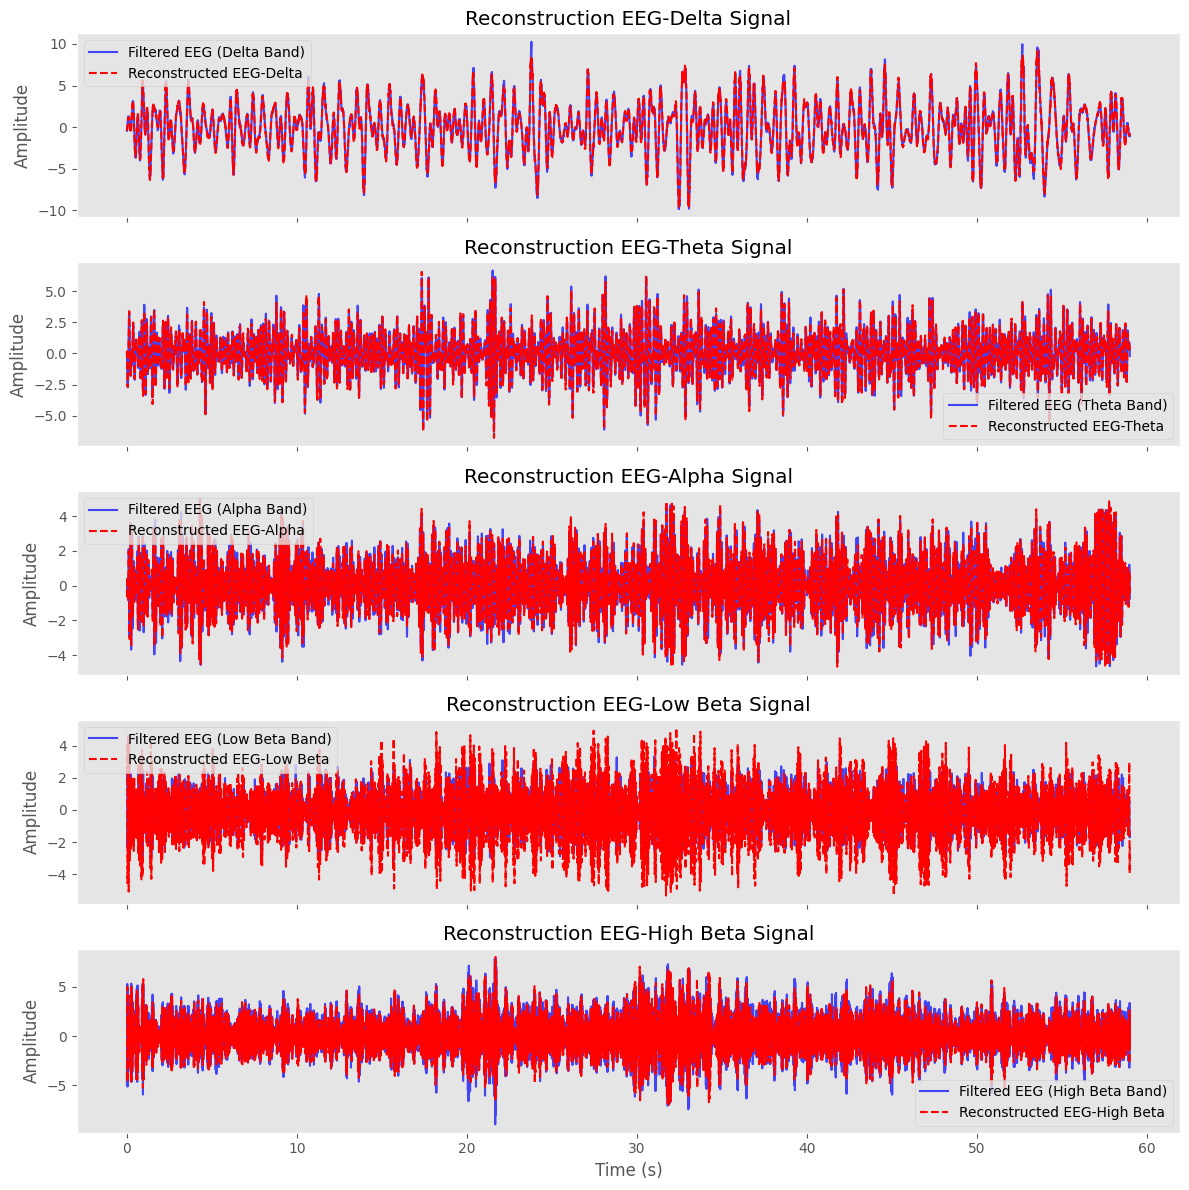

In [ ]:
# Percorso della cartella dove hai salvato i file
save_dir = "/content/drive/MyDrive/Tesi/Reconstructions/"
  # Definire le bande EEG
bands = ["Delta", "Theta", "Alpha", "Low Beta", "High Beta"]

# Creare la figura con 5 subplot
fig, axs = plt.subplots(len(bands), 1, figsize=(12, 12), sharex=True)

for i, band in enumerate(bands):
    # Caricare il segnale ricostruito
    full_reconstructed_signal = np.load(f"{save_dir}full_reconstructed_signal_{band}_{channel}.npy")

    # Selezionare solo la banda specificata
    delta_signal = filtered_signals[band]

    # **Plot del segnale originale vs filtrato**
    axs[i].plot(time_axis, delta_signal, label=f"Filtered EEG ({band} Band)", color="b", alpha=0.7)
    axs[i].plot(time_axis, full_reconstructed_signal, label=f"Reconstructed EEG-{band}", color="r", linestyle="--")
    axs[i].set_ylabel("Amplitude")
    axs[i].set_title(f"Reconstruction EEG-{band} Signal")
    axs[i].legend()
    axs[i].grid()

# Aggiungere etichetta all'asse X solo nell'ultimo subplot
axs[-1].set_xlabel("Time (s)")

# Mostrare il grafico
plt.tight_layout()
plt.show()

#Ricostruzione del segnale EEG originale

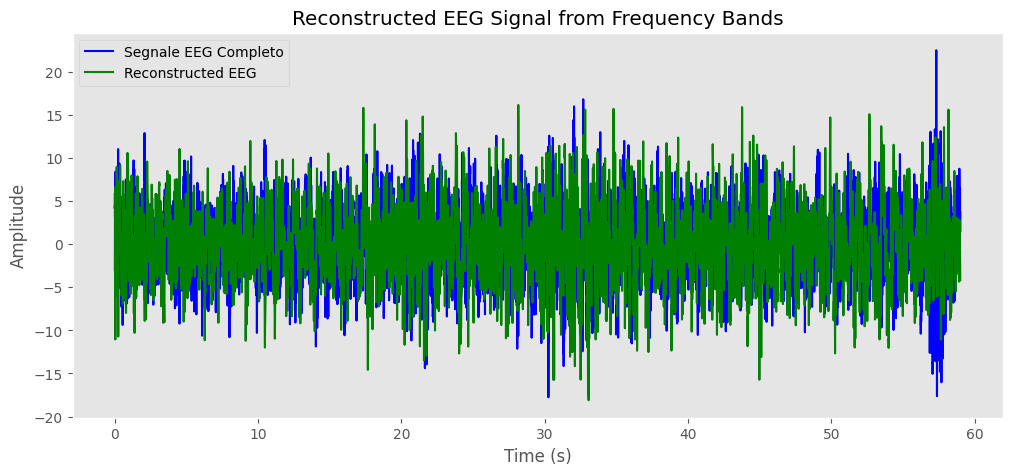

Segnale EEG ricostruito salvato con successo!


In [21]:
# Percorso della cartella dove hai salvato i file
save_dir = "/content/drive/MyDrive/Tesi/Reconstructions"

# Definire le bande EEG
bands = ["Delta", "Theta", "Alpha", "Low Beta", "High Beta"]

# Caricare i segnali filtrati dalle bande salvate
filtered_signals = {}
n = None  # Inizializziamo il numero di campioni
for band in bands:
    filtered_signals[band] = np.load(f"{save_dir}/full_reconstructed_signal_{band}.npy")
    if n is None:
        n = len(filtered_signals[band])  # Prendiamo la lunghezza da uno dei segnali

# Definire la frequenza di campionamento
sampling_rate = 250  # Hz

# Creare il dominio delle frequenze
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)
fft_reconstructed = np.zeros(n, dtype=complex)

# Sommare gli spettri delle diverse bande
for band, signal in filtered_signals.items():
    fft_values = np.fft.fft(signal)  # Calcola la FFT della banda
    fft_reconstructed += fft_values  # Somma i contributi spettrali

# Applicare la trasformata inversa di Fourier per ottenere il segnale EEG ricostruito
eeg_reconstructed = np.fft.ifft(fft_reconstructed).real  # Prendere solo la parte reale

# Creare l'asse temporale
time_axis = np.arange(n) / sampling_rate

# **Plot del segnale ricostruito**
plt.figure(figsize=(12, 5))
plt.plot(time_axis, eeg_data, linestyle='-', color='b', label="Segnale EEG Completo")
plt.plot(time_axis, eeg_reconstructed, label="Reconstructed EEG", color="g")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Reconstructed EEG Signal from Frequency Bands")
plt.legend()
plt.grid()
plt.show()

# Salvare il segnale EEG ricostruito
np.save(f"{save_dir}/reconstructed_eeg.npy", eeg_reconstructed)

print("Segnale EEG ricostruito salvato con successo!")

#Verifica della significatività della ricostruzione

In [ ]:
# Carica il segnale originale
channel = 35  # Selecting channel index 36 (Python indexing starts from 0)
data = pd.read_csv("/content/drive/MyDrive/Tesi/eeg_data.csv")

eeg_data = data.iloc[channel, :].to_numpy()
n = eeg_data.shape[0]
sampling_rate = 250  # Hz
segment_length = sampling_rate  # 1 secondo

# Calcola la variazione di ampiezza per ogni segmento di 1s
num_segments = n // segment_length
amp_variations = []

for i in range(num_segments):
    segment = eeg_data[i * segment_length : (i + 1) * segment_length]
    amp_variations.append(np.max(segment) - np.min(segment))  # Differenza max-min

# Seleziona il segmento con massima variazione
best_segment_index = np.argmax(amp_variations)
best_segment = eeg_data[best_segment_index * segment_length : (best_segment_index + 1) * segment_length]

print(f"Segmento selezionato: {best_segment_index} ({best_segment_index / sampling_rate:.2f} sec)")


Segmento selezionato: 24 (0.10 sec)


In [ ]:
from scipy.stats import ttest_rel, shapiro
import matplotlib.pyplot as plt

# Carica il segnale ricostruito
reconstructed_signal = np.load(f"{save_dir}/reconstructed_eeg.npy")

# Prendi il segmento selezionato
best_segment_reconstructed = reconstructed_signal[best_segment_index * segment_length : (best_segment_index + 1) * segment_length]

# Calcola l'ampiezza media per canale
original_means = np.mean(best_segment)
reconstructed_means = np.mean(best_segment_reconstructed)

# Test di normalità (Shapiro-Wilk)
differences = original_means - reconstructed_means
shapiro_test = shapiro(differences)
print(f"Shapiro-Wilk test: p-value = {shapiro_test.pvalue}")

# Test t-Student per coppie
t_stat, p_value = ttest_rel(original_means, reconstructed_means)
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.3f}")

# Grafico della distribuzione dell'ampiezza media per canale
plt.figure(figsize=(12, 5))
plt.bar(np.arange(original_means.shape[0]), original_means, alpha=0.7, label="Original EEG", color="blue")
plt.bar(np.arange(reconstructed_means.shape[0]), reconstructed_means, alpha=0.7, label="Reconstructed EEG", color="orange")
plt.xlabel("Electrode Index")
plt.ylabel("Mean Amplitude")
plt.title(f"Mean Amplitude Distribution per Electrode (1s segment at {best_segment_index / sampling_rate:.2f} sec)")
plt.legend()
plt.grid()
plt.show()

ValueError: Data must be at least length 3.

#Scelta iperparametri


*   `epochs` --> [500, 5000] in base alla velocità di convergenza o ad eventuale overfitting
*   `freq`--> [10, 500] per monitorare meglio il training, senza appesantire troppo con i logging frequenti
*   `latent_dim` --> [8,128] tra [8,16] potrebbe non catturare abbastanza bene le info, con un valore troppo grande può causare overfitting o training instabile
*   `hideen_dim` -->[20, 256] se il modello è troppo lento e overfitta meglio ridurre a 20-40, altrimenti se il modello è troppo semplice meglio usare 128-256
*   `lstm_hidden_dim` --> [32, 256] Se l’LSTM non cattura la struttura temporale, aumenta il valore (128-256).
Se il modello è troppo pesante, riduci a 32.
* `lstm_layers` --> [1, 4] Un solo strato (1) potrebbe non catturare abbastanza dipendenze temporali.
Più di 3-4 strati (3-4) può causare problemi di vanishing/exploding gradients.
* `lr` -->  [0.0001, 0.01] Valori alti (0.01) possono rendere il training instabile.
Valori bassi (0.0001) possono rallentare troppo il training.





Aggiornamento di PyTorch

In [ ]:
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━